<a href="https://colab.research.google.com/github/ezesalvatore/CaliFirePrediction-LSTM/blob/main/CaliforniaWildfireRiskPredictionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# California Wildfire Risk Prediction System




# **Project Overview**
  This machine learning project LSTM models with full-stack web development to create an wildfire prediction system for California.


## **Project Motivations**
In recent years, California has experience massive wildfire seasons, with climate change only increasing the frequency and destructiveness of these fires. My mission is to prevent wildfires by predicting if they will happen. The prediction will give communities, firefighters, and other emergency services a head start.

## **Tech Stack**

* **Datasets** of historical fire data
* **LSTM models** built with TensorFlow/Keras trained in google collab
* **Django** backends uses trained models with real-time API data
* **React** displays interactive map interface with warnings

# **Dataset Documentation**

This documents information about the California Wildfire Risk Prediction System dataset being used. This inculdes its source, date range, variables, limitations, and citation information.


##CAL FIRE Historic Wildland Fire Perimeters Dataset Documentation
**Date Range** 1878- Present (Oldest and Cohesive on Cal Fire documentation <br>
**Data Source** [California Department of Forestry and Fire Protection's Fire and Resource Assessment Program (FRAP)](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/fire-perimeters)
###**Limiation of Dataset**
This is the most complete dataset for califorina history, but there are 483 fires that are totally missing from the CAL FIRE Redbook "Large, Damaging Fires"
###**Data Collection of dataset**
CAL Fire document fires that are: <br> >= 10 acres in timber <br> >= 50 acres in brush <br> >= 300 acres in grass <br>  >= 1 fatality <br> >= 3 residential building burned
###**Variables used:**
`ALARM_DATE`= Fire start date <br>
`geometry` = Fire perimeter coordinates <br>
`GIS_ACRES` = Fire size in acres
###**Variables from Code**
`fire_occurred` = Binary target variable (0 = no fire, 1 = fire happened)<br>
`fire_size_acres` = Filtered fire size (>= 10 acres only)<br>


## **NOAA National Centers for Environmental Information Dataset Documentation**<br>
**Date Range:** January 1, 2009 - December 31, 2013 <br>
**Data Source:** [NOAA GHCN-Daily dataset](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND)
###**Station Location:**
Arcata Eureka Airport `USW00024283` <br>
Redding Airport `USW00024257` <br> Marysville Airport `USW00093205`<br>
Napa Airport `USW00093227`  <br> Santa Maria Airport `USW00023273`  <br> Watsonville Airport `USW00023277` <br> Stockton Airport `USW00023237` <br>
Merced Municipal Airport `USW00023257`<br> Fresno Yosemite International `USW00093193` <br> Bakersfield Airport `USW00023155`  <br>
 Santa Barbara 11W `USW00023190`<br>  Burbank-Glendale-Pasadena Airport `USW00023152` <br> Oceanside Airport `USW00053121`

###**Variables Collected from Dataset:**
`PRCP` = Precipitation (mm) <br>
`TMAX`= Max Temp (°C) <br>
`TMIN` = Min Temp (°C) <br>
`AWND` = Average Wind Speed (m/s)

###**Variables from Code**
`temperature_range` = TMAX-TMIN <br>
`days_since_rain` = Days with PRCP < 0.25 <br>
`fire_season` = May - October period <br>
`station_id` = Weather station <br>


###**Citation**
National Centers for Environmental Information, NOAA.(2025)


##**Stations locations**

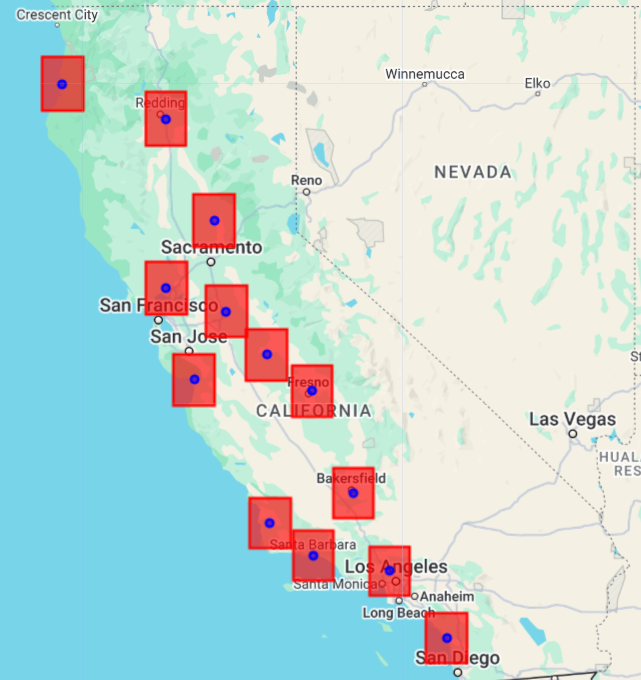

##**Modis NDVI Dataset**
**Date Range:** 2000-Present <br>
**Data Source:** [Google Earth Engine - MODIS/061/MOD13Q1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13Q1)

###**Regional Coverage**
Since Califorina is made up with different regions with vastly differnt climate I separated the region my polygons will collect the data

###**Data Collection Method**
```python
modis_ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .select('NDVI') \
    .filterDate('2009-01-01', '2013-12-31')
```

###**Variables from Dataset**
`NDVI`= Raw MODIS NDVI band values (range: -1 to +1)

###**Variables from Code**
`ndvi_mean` = average NDVI for each fire region <br>
`ndvi_stdev` = measure of NDVI variation<br>
`region` = fire zone

###**Citation**
LP DAAC. (2021). MOD13Q1 MODIS/Terra Vegetation Indices 16-Day L3 Global 250m V061. NASA EOSDIS Land Processes DAAC.

#**Dataset Creation**

In [ ]:
import os

base_path = '/content/drive/MyDrive/fire_prediction_project'
folders = [
    'raw_data/fires_calfire',
    'raw_data/weather_ghcn',
    'raw_data/vegetation_modis',
]

for folder in folders:
    full_path = f'{base_path}/{folder}'
    os.makedirs(full_path, exist_ok=True)
    print(f"Created: {folder}")

In [ ]:
#Check if data exists

print(os.listdir('/content/drive/MyDrive/fire_prediction_project/raw_data/fires_calfire'))
print(os.listdir('/content/drive/MyDrive/fire_prediction_project/raw_data/weather_ghcn'))
print(os.listdir('/content/drive/MyDrive/fire_prediction_project/raw_data/vegetation_modis'))


# **Fire Perimeters Loading, Cleaning, Visulization data retrieved**

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

def load_fire_data():
    """
    Loads CAL FIRE data and creates LSTM targets directly.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
            - study_fires (pd.DataFrame or None): DataFrame of filtered fire incidents within the study period, or None if loading fails.
            - daily_targets (pd.DataFrame or None): DataFrame of daily fire occurrence targets for LSTM, or None if loading fails.
    """
    fire_folder = '/content/drive/MyDrive/fire_prediction_project/raw_data/fires_calfire'
    print(f"Looking for fire data in: {fire_folder}")

    if not os.path.exists(fire_folder):
        print("Error: Fire folder not found!")
        return None, None

    shp_files = [f for f in os.listdir(fire_folder) if f.endswith('.shp')]
    if not shp_files:
        print("Note: No fire shapefiles found.")
        return None, None

    print(f"Found {len(shp_files)} shapefile(s)")
    first_shp_file = f'{fire_folder}/{shp_files[0]}'

    try:
        fire_gdf = gpd.read_file(first_shp_file)
        print(f"Loaded {len(fire_gdf)} fire records")
        return process_fire_data(fire_gdf)
    except Exception as e:
        print(f"Error loading shapefile: {e}")
        return None, None

def process_fire_data(fire_gdf):
    """
    Process fire data and create LSTM targets.

    Args:
        fire_gdf (gpd.GeoDataFrame): GeoDataFrame containing the raw fire data.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
            - study_fires (pd.DataFrame): DataFrame of processed and filtered fire incidents.
            - daily_targets (pd.DataFrame): DataFrame of daily fire occurrence targets for LSTM.
    """
    print("Processing fire data...")

    # Convert to WGS84 which is a common lat/longitude system
    if fire_gdf.crs != 'EPSG:4326':
        fire_gdf = fire_gdf.to_crs('EPSG:4326')

    # Drop the geometry to get the center of the fire perimeter
    fire_df = pd.DataFrame(fire_gdf.drop(columns='geometry'))

    # Get the center of fire geometry
    centroids = fire_gdf.geometry.centroid
    fire_df['centroid_lat'] = centroids.y
    fire_df['centroid_lon'] = centroids.x

    # Updated comprehensive weather station coordinates
    weather_stations = [
        {'name': 'Arcata Eureka Airport', 'usw_id': 'USW00024283', 'lat': 40.97844, 'lon': -124.10479},
        {'name': 'Redding Airport', 'usw_id': 'USW00024257', 'lat': 40.51, 'lon': -122.29},
        {'name': 'Marysville Airport (Beale AFB)', 'usw_id': 'USW00093205', 'lat': 39.136089, 'lon': -121.436567},
        {'name': 'Napa Airport', 'usw_id': 'USW00093227', 'lat': 38.213194, 'lon': -122.280694},
        {'name': 'Stockton Airport', 'usw_id': 'USW00023237', 'lat': 37.88997, 'lon': -121.22637},
        {'name': 'Fresno Yosemite International', 'usw_id': 'USW00093193', 'lat': 36.77999, 'lon': -119.72016},
        {'name': 'Santa Maria Airport', 'usw_id': 'USW00023273', 'lat': 34.8927, 'lon': -120.4545},
        {'name': 'Watsonville Airport', 'usw_id': 'USW00023277', 'lat': 36.935, 'lon': -121.79},
        {'name': 'Merced Municipal Airport', 'usw_id': 'USW00023257', 'lat': 37.28470, 'lon': -120.51400},
        {'name': 'Bakersfield Airport', 'usw_id': 'USW00023155', 'lat': 35.3217, 'lon': -118.9910},
        {'name': 'Santa Barbara 11W', 'usw_id': 'USW00023190', 'lat': 34.4208, 'lon': -119.6982},
        {'name': 'Burbank-Glendale-Pasadena Airport', 'usw_id': 'USW00023152', 'lat': 34.2003, 'lon': -118.3552},
        {'name': 'Oceanside Airport', 'usw_id': 'USW00023181', 'lat': 33.218, 'lon': -117.351}
    ]

    def find_nearest_weather_station(lat, lon):
        """
        Find the nearest weather station to given coordinates.

        Args:
            lat (float): Latitude coordinate of the fire
            lon (float): Longitude coordinate of the fire

        Returns:
            str: USW ID of the nearest weather station
        """
        if pd.isna(lat) or pd.isna(lon):
            return 'Unknown'

        # Check if within California bounds (rough bounds)
        if not (32.4 <= lat <= 42.2 and -124.6 <= lon <= -114.0):
            return 'Unknown'

        min_distance = float('inf')
        nearest_station = 'Unknown'

        for station in weather_stations:
            # Calculate Euclidean distance (approximate since we're dealing with small distances)
            distance = np.sqrt((lat - station['lat'])**2 + (lon - station['lon'])**2)

            if distance < min_distance:
                min_distance = distance
                nearest_station = station['usw_id']

        return nearest_station

    # Assign each fire to its nearest weather station
    fire_df['weather_station'] = fire_df.apply(
        lambda row: find_nearest_weather_station(row['centroid_lat'], row['centroid_lon']),
        axis=1
    )

    # Renaming columns to match expected format
    column_mapping = {
        'ALARM_DATE': 'fire_date',
        'GIS_ACRES': 'fire_size_acres',
        'YEAR_': 'year'
    }
    for old_name, new_name in column_mapping.items():
        if old_name in fire_df.columns:
            fire_df = fire_df.rename(columns={old_name: new_name})

    # Process dates and filter
    if 'fire_date' not in fire_df.columns:
        print("Warning: 'fire_date' column not found.")
        return None, None

    fire_df['fire_date'] = pd.to_datetime(fire_df['fire_date'], errors='coerce')
    fire_df = fire_df.dropna(subset=['fire_date'])

    # Filter to study period and significant fires
    study_fires = fire_df[
        (fire_df['fire_date'] >= '2009-01-01') &
        (fire_df['fire_date'] <= '2013-12-31')
    ].copy()

    if 'fire_size_acres' in study_fires.columns:
        study_fires = study_fires[study_fires['fire_size_acres'] >= 10]

    print(f"Study period fires: {len(study_fires)} (2009-2013)")

    # Print distribution by weather station
    print("\nFire distribution by weather station:")
    station_counts = study_fires['weather_station'].value_counts()
    for station_id, count in station_counts.items():
        station_name = next((s['name'] for s in weather_stations if s['usw_id'] == station_id), station_id)
        print(f"  {station_name} ({station_id}): {count} fires")

    # Create LSTM targets
    daily_targets = create_daily_fire_targets(study_fires)

    return study_fires, daily_targets

def create_daily_fire_targets(fire_df):
    """
    Creates 5-day fire prediction targets for LSTM training.

    Args:
        fire_df (pd.DataFrame): DataFrame of fire incidents with 'fire_date' and 'weather_station' columns.

    Returns:
        pd.DataFrame: DataFrame with daily 5-day fire prediction targets.
    """
    print("Creating 5-day fire prediction targets...")

    if 'fire_date' not in fire_df.columns or 'weather_station' not in fire_df.columns:
        print("Warning: Missing required columns for targets.")
        return None

    # Create date range - end 5 days early to allow for 5-day prediction window
    date_range = pd.date_range('2009-01-01', '2013-12-26', freq='D')  # Dec 26 instead of Dec 31
    stations = fire_df['weather_station'].unique()
    stations = [s for s in stations if s != 'Unknown']

    # Build daily targets
    daily_targets = []
    for date in date_range:
        for station in stations:
            # Look for fires in the next 5 days (tomorrow through day 5)
            window_start = date + pd.Timedelta(days=1)
            window_end = date + pd.Timedelta(days=5)

            fires_in_window = fire_df[
                (fire_df['fire_date'] >= window_start) &
                (fire_df['fire_date'] <= window_end) &
                (fire_df['weather_station'] == station)
            ]

            daily_targets.append({
                'date': date,
                'weather_station': station,
                'fire_within_5_days': 1 if len(fires_in_window) > 0 else 0
            })

    targets_df = pd.DataFrame(daily_targets)

    # Print statistics
    positive_rate = targets_df['fire_within_5_days'].mean() * 100
    print(f"Created {len(targets_df)} daily target records")
    print(f"5-day fire prediction rate: {positive_rate:.1f}%")

    return targets_df

# Load and process fire data
print("Loading fire data with updated weather stations...")
fire_data, fire_targets = load_fire_data()

print(f"\nFire data shape: {fire_data.shape if fire_data is not None else 'None'}")
print(f"LSTM targets shape: {fire_targets.shape if fire_targets is not None else 'None'}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_fire_data(fire_data, fire_targets):
    """Simple fire data visualizations"""

    # Set up the plot style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🔥 California Fire Data Overview (2009-2013)', fontsize=16, fontweight='bold')

    # 1. Fires by Weather Station
    station_counts = fire_data['weather_station'].value_counts()
    axes[0,0].bar(range(len(station_counts)), station_counts.values, color='orangered', alpha=0.7)
    axes[0,0].set_title('Total Fires by Region')
    axes[0,0].set_ylabel('Number of Fires')
    axes[0,0].set_xlabel('Weather Stations')
    axes[0,0].set_xticks(range(len(station_counts)))
    axes[0,0].set_xticklabels([s[-6:] for s in station_counts.index], rotation=45)  # Show last 6 chars of station ID

    # 2. Fire Size Distribution
    axes[0,1].hist(fire_data['fire_size_acres'], bins=30, color='red', alpha=0.6, edgecolor='black')
    axes[0,1].set_title('Fire Size Distribution')
    axes[0,1].set_xlabel('Fire Size (acres)')
    axes[0,1].set_ylabel('Number of Fires')
    axes[0,1].set_yscale('log')  # Log scale because of wide range

    # 3. Monthly Fire Pattern
    fire_data['month'] = fire_data['fire_date'].dt.month
    monthly_fires = fire_data['month'].value_counts().sort_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    axes[1,0].plot(monthly_fires.index, monthly_fires.values, 'o-',
                   linewidth=3, markersize=8, color='darkred')
    axes[1,0].set_title('Fires by Month')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Number of Fires')
    axes[1,0].set_xticks(range(1, 13))
    axes[1,0].set_xticklabels(months, rotation=45)
    axes[1,0].grid(True, alpha=0.3)

    # 4. Fire Risk Rate by Station
    if 'fire_within_5_days' in fire_targets.columns:
        risk_by_station = fire_targets.groupby('weather_station')['fire_within_5_days'].mean() * 100
    else:
        # Fallback if column name is different
        risk_by_station = fire_targets.groupby('weather_station').iloc[:,2].mean() * 100

    axes[1,1].bar(range(len(risk_by_station)), risk_by_station.values,
                  color='orange', alpha=0.7)
    axes[1,1].set_title('5-Day Fire Risk by Region')
    axes[1,1].set_ylabel('Fire Risk (%)')
    axes[1,1].set_xlabel('Weather Stations')
    axes[1,1].set_xticks(range(len(risk_by_station)))
    axes[1,1].set_xticklabels([s[-6:] for s in risk_by_station.index], rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Summary Statistics
    print("\n" + "="*50)
    print("🔥 FIRE DATA SUMMARY")
    print("="*50)
    print(f"📊 Total Fires: {len(fire_data):,}")
    print(f"📅 Date Range: {fire_data['fire_date'].min().strftime('%Y-%m-%d')} to {fire_data['fire_date'].max().strftime('%Y-%m-%d')}")
    print(f"🌡️ Weather Stations: {fire_data['weather_station'].nunique()}")
    print(f"🔢 Average Fire Size: {fire_data['fire_size_acres'].mean():.0f} acres")
    print(f"📈 Largest Fire: {fire_data['fire_size_acres'].max():,.0f} acres")

    # Fire season analysis
    fire_season_fires = fire_data[fire_data['fire_date'].dt.month.isin([5,6,7,8,9,10])]
    fire_season_pct = (len(fire_season_fires) / len(fire_data)) * 100
    print(f"🌡️ Fire Season (May-Oct): {fire_season_pct:.1f}% of all fires")

    # LSTM targets summary
    if fire_targets is not None:
        total_days = len(fire_targets)
        fire_days = fire_targets.iloc[:,2].sum() if fire_targets.shape[1] > 2 else 0
        overall_risk = (fire_days / total_days) * 100 if total_days > 0 else 0
        print(f"🎯 Overall 5-Day Fire Risk: {overall_risk:.1f}%")
        print(f"📋 LSTM Training Records: {total_days:,}")

    print("="*50)

# Simple usage example:
visualize_fire_data(fire_data, fire_targets)

# **NOAA load, clean, visulization, and retrival**

In [ ]:
import pandas as pd
import numpy as np
import os

def load_weather_data():
    """
    Load and process weather data from NOAA GHCN-Daily dataset for fire prediction.

    Returns:
        pd.DataFrame: Processed weather data with engineered features, or None if loading fails.
    """
    weather_path = '/content/drive/MyDrive/fire_prediction_project/raw_data/weather_ghcn/4030855.csv'

    print(f"Loading weather data from: {weather_path}")

    if not os.path.exists(weather_path):
        print("Error: Weather file not found!")
        return None

    try:
        # Load the weather data
        weather_df = pd.read_csv(weather_path)
        print(f"Loaded {len(weather_df)} weather records")

        # Process the weather data
        processed_weather = process_weather_data(weather_df)

        return processed_weather

    except Exception as e:
        print(f"Error loading weather data: {e}")
        return None

def process_weather_data(weather_df):
    """
    Process raw weather data and create engineered features.

    Args:
        weather_df (pd.DataFrame): Raw weather data from NOAA

    Returns:
        pd.DataFrame: Processed weather data with engineered features
    """
    print("Processing weather data...")

    # Convert date column
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

    # Filter to study period
    weather_df = weather_df[
        (weather_df['DATE'] >= '2009-01-01') &
        (weather_df['DATE'] <= '2013-12-31')
    ].copy()

    # Rename columns for consistency
    weather_df = weather_df.rename(columns={
        'DATE': 'date',
        'STATION': 'weather_station'
    })

    # Convert temperature from tenths of degrees C to degrees C
    if 'TMAX' in weather_df.columns:
        weather_df['TMAX'] = weather_df['TMAX'] / 10.0
    if 'TMIN' in weather_df.columns:
        weather_df['TMIN'] = weather_df['TMIN'] / 10.0

    # Convert precipitation from tenths of mm to mm
    if 'PRCP' in weather_df.columns:
        weather_df['PRCP'] = weather_df['PRCP'] / 10.0

    # Convert wind speed from tenths of m/s to m/s
    if 'AWND' in weather_df.columns:
        weather_df['AWND'] = weather_df['AWND'] / 10.0

    # Create engineered features
    weather_df = create_weather_features(weather_df)

    print(f"Processed weather data: {len(weather_df)} records")
    print(f"Date range: {weather_df['date'].min().date()} to {weather_df['date'].max().date()}")
    print(f"Weather stations: {weather_df['weather_station'].nunique()}")

    return weather_df

def create_weather_features(weather_df):
    """
    Create engineered weather features for fire prediction.

    Args:
        weather_df (pd.DataFrame): Basic weather data

    Returns:
        pd.DataFrame: Weather data with engineered features
    """
    print("Creating weather features...")

    # Temperature range
    if 'TMAX' in weather_df.columns and 'TMIN' in weather_df.columns:
        weather_df['temperature_range'] = weather_df['TMAX'] - weather_df['TMIN']

    # Fire season indicator (May - October)
    weather_df['fire_season'] = weather_df['date'].dt.month.isin([5, 6, 7, 8, 9, 10]).astype(int)

    # Add wind strength features
    weather_df = add_wind_strength(weather_df)

    # Days since rain (calculated per weather station)
    weather_df = weather_df.sort_values(['weather_station', 'date'])

    def calculate_days_since_rain(group):
        """Calculate days since last significant rain (>= 0.25mm) for each station"""
        group = group.copy()
        group['days_since_rain'] = 0

        if 'PRCP' in group.columns:
            last_rain_day = 0
            for i, row in group.iterrows():
                if pd.notna(row['PRCP']) and row['PRCP'] >= 0.25:
                    last_rain_day = 0
                else:
                    last_rain_day += 1
                group.loc[i, 'days_since_rain'] = last_rain_day

        return group

    # Apply days since rain calculation by weather station
    weather_df = weather_df.groupby('weather_station').apply(calculate_days_since_rain).reset_index(drop=True)

    # Fill missing values
    weather_df['PRCP'] = weather_df['PRCP'].fillna(0)
    weather_df['AWND'] = weather_df['AWND'].fillna(weather_df['AWND'].mean())

    # Select final columns
    feature_columns = [
        'date', 'weather_station', 'PRCP', 'TMAX', 'TMIN', 'AWND',
        'temperature_range', 'days_since_rain', 'fire_season',
        'wind_mph', 'wind_strength'
    ]

    # Only keep columns that exist
    available_columns = [col for col in feature_columns if col in weather_df.columns]
    weather_df = weather_df[available_columns]

    print(f"Weather features created: {list(weather_df.columns)}")

    # Print basic statistics
    print("\nWeather data summary:")
    print(f"  Average TMAX: {weather_df['TMAX'].mean():.1f}°C")
    print(f"  Average TMIN: {weather_df['TMIN'].mean():.1f}°C")
    print(f"  Average PRCP: {weather_df['PRCP'].mean():.1f}mm")
    print(f"  Average wind: {weather_df['wind_mph'].mean():.1f} mph")
    print(f"  Fire season days: {weather_df['fire_season'].sum()}")
    print(f"  Max days since rain: {weather_df['days_since_rain'].max()}")

    # Wind strength summary
    print(f"\n🌪️ Wind strength summary:")
    print(weather_df['wind_strength'].value_counts())

    return weather_df

def add_wind_strength(weather_df):
    """
    Add simple wind strength categories for fire danger.

    Args:
        weather_df: Weather dataframe with 'AWND' column

    Returns:
        DataFrame with wind strength features added
    """

    # Convert wind speed to mph (AWND is in m/s)
    weather_df['wind_mph'] = weather_df['AWND'] * 2.237

    # Simple wind strength categories
    def get_wind_strength(wind_mph):
        if wind_mph >= 25:
            return 'EXTREME'      # Santa Ana/Diablo conditions
        elif wind_mph >= 15:
            return 'HIGH'         # Fire danger threshold
        elif wind_mph >= 8:
            return 'MODERATE'     # Elevated risk
        else:
            return 'LOW'          # Normal conditions

    weather_df['wind_strength'] = weather_df['wind_mph'].apply(get_wind_strength)

    return weather_df

# Load weather data
print("Loading weather data...")
weather_data = load_weather_data()

if weather_data is not None:
    print(f"\nWeather data shape: {weather_data.shape}")
    print("\nSample weather data:")
    print(weather_data.head())
else:
    print("Failed to load weather data.")

# **Google Earth Engine Code for NDVI Data Retrieval**

In [ ]:
import ee

# Initialize GEE
ee.Authenticate()
ee.Initialize(project='fire-prediction-ee-salvatore')

# Define California state boundary for intersection
california = ee.FeatureCollection("TIGER/2018/States") \
    .filter(ee.Filter.eq('STUSPS', 'CA')) \
    .geometry()

# Updated comprehensive weather station locations
weather_stations = [
    {'name': 'Arcata Eureka Airport', 'usw': 'USW00024283', 'lat': 40.97844, 'lon': -124.10479},
    {'name': 'Redding Airport', 'usw': 'USW00024257', 'lat': 40.51, 'lon': -122.29},
    {'name': 'Marysville Airport (Beale AFB)', 'usw': 'USW00093205', 'lat': 39.136089, 'lon': -121.436567},
    {'name': 'Napa Airport', 'usw': 'USW00093227', 'lat': 38.213194, 'lon': -122.280694},
    {'name': 'Stockton Airport', 'usw': 'USW00023237', 'lat': 37.88997, 'lon': -121.22637},
    {'name': 'Fresno Yosemite International', 'usw': 'USW00093193', 'lat': 36.77999, 'lon': -119.72016},
    {'name': 'Santa Maria Airport', 'usw': 'USW00023273', 'lat': 34.8927, 'lon': -120.4545},
    {'name': 'Watsonville Airport', 'usw': 'USW00023277', 'lat': 36.935, 'lon': -121.79},
    {'name': 'Merced Municipal Airport', 'usw': 'USW00023257', 'lat': 37.28470, 'lon': -120.51400},
    {'name': 'Bakersfield Airport', 'usw': 'USW00023155', 'lat': 35.3217, 'lon': -118.9910},
    {'name': 'Santa Barbara 11W', 'usw': 'USW00023190', 'lat': 34.4208, 'lon': -119.6982},
    {'name': 'Burbank-Glendale-Pasadena Airport', 'usw': 'USW00023152', 'lat': 34.2003, 'lon': -118.3552},
    {'name': 'Oceanside Airport', 'usw': 'USW00023181', 'lat': 33.218, 'lon': -117.351}
]

# Square size in kilometers
square_size_km = 80

def create_weather_station_square(station_info, size_km):
    """Create a square polygon around a weather station"""
    lat = station_info['lat']
    lon = station_info['lon']

    # Convert km to degrees (approximate: 1 degree ≈ 111 km)
    size_deg = size_km / 111

    # Create square coordinates
    coords = [
        [lon - size_deg/2, lat - size_deg/2],  # southwest
        [lon + size_deg/2, lat - size_deg/2],  # southeast
        [lon + size_deg/2, lat + size_deg/2],  # northeast
        [lon - size_deg/2, lat + size_deg/2],  # northwest
        [lon - size_deg/2, lat - size_deg/2]   # close polygon
    ]

    polygon = ee.Geometry.Polygon([coords])

    # Intersect with California boundary to ensure we stay within state
    return polygon.intersection(california)

# Create weather station regions dictionary
weather_regions = {}
for station in weather_stations:
    # Use USW ID as region identifier (clean version for naming)
    region_key = f"{station['usw']}_{station['name'].replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')}"
    weather_regions[region_key] = create_weather_station_square(station, square_size_km)

# Load MODIS NDVI
modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .select('NDVI') \
    .filterDate('2009-01-01', '2013-12-31') \
    .map(lambda img: img.multiply(0.0001).copyProperties(img, ['system:time_start']))

# Extract NDVI for all weather station regions
features = []
for region_name, geometry in weather_regions.items():
    def extract_ndvi(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev().combine(
                    ee.Reducer.min().combine(
                        ee.Reducer.max(),
                        sharedInputs=True
                    ),
                    sharedInputs=True
                ),
                sharedInputs=True
            ),
            geometry=geometry,
            scale=250,
            maxPixels=1e9
        )

        return ee.Feature(None, {
            'region': region_name,
            'usw_id': region_name.split('_')[0],  # Extract USW ID
            'station_name': '_'.join(region_name.split('_')[1:]),  # Extract station name
            'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'),
            'ndvi_mean': stats.get('NDVI_mean'),
            'ndvi_stddev': stats.get('NDVI_stdDev'),
            'ndvi_min': stats.get('NDVI_min'),
            'ndvi_max': stats.get('NDVI_max')
        })

    region_features = modis.map(extract_ndvi)
    features.append(region_features)

# Combine and export
combined = ee.FeatureCollection(features).flatten()

# Export task
task = ee.batch.Export.table.toDrive(
    collection=combined,
    description='california_weather_station_ndvi',
    folder='fire_prediction_project/raw_data/vegetation_modis',
    fileNamePrefix='california_weather_station_ndvi',
    fileFormat='CSV'
)

task.start()
print("Export task started!")
print("Monitor progress at: https://code.earthengine.google.com/tasks")

# Print summary information
print(f"\nProcessing {len(weather_stations)} weather stations:")
for station in weather_stations:
    print(f"  - {station['name']} ({station['usw']})")
print(f"\nSquare size: {square_size_km}km x {square_size_km}km")
print(f"Total regions: {len(weather_regions)}")


In [ ]:
import pandas as pd

def load_and_clean_ndvi():
    """Load, clean, and prepare NDVI data"""
    # Load NDVI data
    ndvi_path = '/content/drive/MyDrive/fire_prediction_project/raw_data/vegetation_modis/california_weather_station_ndvi.csv'
    ndvi_df = pd.read_csv(ndvi_path)

    # Clean data
    ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
    ndvi_df = ndvi_df.dropna(subset=['ndvi_mean'])
    ndvi_df = ndvi_df[(ndvi_df['ndvi_mean'] >= -0.2) & (ndvi_df['ndvi_mean'] <= 1.0)]

    # Add basic features
    ndvi_df['vegetation_stress'] = 1 - ndvi_df['ndvi_mean'].clip(0, 1)
    ndvi_df['month'] = ndvi_df['date'].dt.month
    ndvi_df['day_of_year'] = ndvi_df['date'].dt.dayofyear

    print(f"Shape: {ndvi_df.shape}")
    print(f"Date range: {ndvi_df['date'].min().date()} to {ndvi_df['date'].max().date()}")
    print(f"Regions: {ndvi_df['region'].nunique()}")

    return ndvi_df

# Load NDVI data
ndvi_data = load_and_clean_ndvi()
print("\nFirst 5 rows:")
print(ndvi_data.head())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("Set2")

def visualize_ndvi(ndvi_data):
    """Simple NDVI visualizations"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('NDVI Data Overview', fontsize=16, fontweight='bold')

    # 1. NDVI by Region (Box plot)
    axes[0,0].boxplot([ndvi_data[ndvi_data['region']==r]['ndvi_mean']
                       for r in ndvi_data['region'].unique()],
                      labels=ndvi_data['region'].unique())
    axes[0,0].set_title('NDVI Distribution by Region')
    axes[0,0].set_ylabel('NDVI')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. NDVI Time Series by Region
    for region in ndvi_data['region'].unique():
        region_data = ndvi_data[ndvi_data['region'] == region]
        axes[0,1].plot(region_data['date'], region_data['ndvi_mean'],
                       label=region, alpha=0.7)
    axes[0,1].set_title('NDVI Over Time')
    axes[0,1].set_ylabel('NDVI')
    axes[0,1].legend()
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Seasonal NDVI Pattern
    monthly_ndvi = ndvi_data.groupby('month')['ndvi_mean'].mean()
    axes[1,0].plot(monthly_ndvi.index, monthly_ndvi.values, 'o-', linewidth=2)
    axes[1,0].set_title('Seasonal NDVI Pattern')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Average NDVI')
    axes[1,0].set_xticks(range(1,13))

    # 4. Vegetation Stress Distribution
    axes[1,1].hist(ndvi_data['vegetation_stress'], bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Vegetation Stress Distribution')
    axes[1,1].set_xlabel('Vegetation Stress (1 - NDVI)')
    axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Summary stats
    print("\n📊 NDVI Summary by Region:")
    summary = ndvi_data.groupby('region')['ndvi_mean'].agg(['mean', 'std', 'min', 'max'])
    print(summary.round(3))

# Run visualization
visualize_ndvi(ndvi_data)